<a href="https://colab.research.google.com/github/prokaj/tabnet/blob/main/TabNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import importlib
if importlib.util.find_spec('pytorch-tabnet') is None:
    !pip install pytorch-tabnet

#!pip install wget


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.4 MB/s eta 0:00:00


In [4]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE
from pytorch_tabnet.pretraining import TabNetPretrainer

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import scipy

import os
# import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
torch.cuda.get_device_capability()

RuntimeError: ignored

In [6]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = f"1"

# import torch
torch.__version__

'2.1.0+cu118'

# Data reading

In [7]:
if False:
    from zipfile import ZipFile

    from google.colab import files
    upload = files.upload()

    zip_file = ZipFile('archive.zip')
    dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
        for text_file in zip_file.infolist()
        if text_file.filename.endswith('.csv')}

In [8]:
import urllib.request as request
from zipfile import ZipFile

url = "https://github.com/szendiagoston/TabNet/raw/main/archive.zip"
request.urlretrieve(url,'archive.zip')
! unzip archive

zip_file = ZipFile('archive.zip')
dfs = {
    text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
    for text_file in zip_file.infolist() if text_file.filename.endswith('.csv')
    }

Archive:  archive.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# EDA

In [ ]:
dfs['train.csv']

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,ID58588,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
58588,ID58589,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58589,ID58590,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58590,ID58591,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0


In [ ]:
[col for col in dfs['train.csv'].columns]

['policy_id',
 'policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'area_cluster',
 'population_density',
 'make',
 'segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'airbags',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'displacement',
 'cylinder',
 'transmission_type',
 'gear_box',
 'steering_type',
 'turning_radius',
 'length',
 'width',
 'height',
 'gross_weight',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert',
 'ncap_rating',
 'is_claim']

In [ ]:
[sum(dfs['train.csv'][col].isnull()) for col in dfs['train.csv'].columns] #nincs hiányzó adat

dfs['train.csv'].isna().any() #van-e hiányzó adat? -> nincs

policy_id                           False
policy_tenure                       False
age_of_car                          False
age_of_policyholder                 False
area_cluster                        False
population_density                  False
make                                False
segment                             False
model                               False
fuel_type                           False
max_torque                          False
max_power                           False
engine_type                         False
airbags                             False
is_esc                              False
is_adjustable_steering              False
is_tpms                             False
is_parking_sensors                  False
is_parking_camera                   False
rear_brakes_type                    False
displacement                        False
cylinder                            False
transmission_type                   False
gear_box                          

In [ ]:
dfs['train.csv'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [ ]:
dfs['train.csv'].describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,1.763722,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.136988,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


In [9]:
train = dfs['train.csv'].drop(columns = ['policy_id']) #id nem kell

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 10: #Levettem 200-ról 10-re -> kicsit javított: best valid auc 0,66161
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        #train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    #else:
        #train.fillna(train.loc[train_indices, col].mean(), inplace=True)

area_cluster 22
make 5
segment 6
model 11
fuel_type 3
max_torque 9
max_power 9
engine_type 11
airbags 3
is_esc 2
is_adjustable_steering 2
is_tpms 2
is_parking_sensors 2
is_parking_camera 2
rear_brakes_type 2
displacement 9
cylinder 2
transmission_type 2
gear_box 2
steering_type 3
turning_radius 9
length 9
is_front_fog_lights 2
is_rear_window_wiper 2
is_rear_window_washer 2
is_rear_window_defogger 2
is_brake_assist 2
is_power_door_locks 2
is_central_locking 2
is_power_steering 2
is_driver_seat_height_adjustable 2
is_day_night_rear_view_mirror 2
is_ecw 2
is_speed_alert 2
ncap_rating 5
is_claim 2


In [10]:
import sklearn.model_selection as ms

In [ ]:
ms.train_test_split?
 #HF

SyntaxError: ignored

In [11]:
target = 'is_claim'

if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.9, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
#test_indices = train[train.Set=="test"].index

In [12]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [44]:
len(cat_idxs)*8+9, train.shape, sum(cat_dims) #plicy_tenure kivételével mind az...

(289, (58592, 44), 156)

grouped_features???

In [14]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

#X_test = train[features].values[test_indices]
#y_test = train[target].values[test_indices]

In [37]:
# TabNetPretrainer
EMB_DIM = 8
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=EMB_DIM,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    n_a = 32,
    n_d = 32,
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [38]:
max_epochs = 2 if not os.getenv("CI", False) else 2

In [39]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs,
    patience=5,
    batch_size=2048,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
)

epoch 0  | loss: 562.88033| val_0_unsup_loss_numpy: 30.655500411987305|  0:00:07s
Stop training because you reached max_epochs = 2 with best_epoch = 1 and best_val_0_unsup_loss_numpy = 2.7804200649261475


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


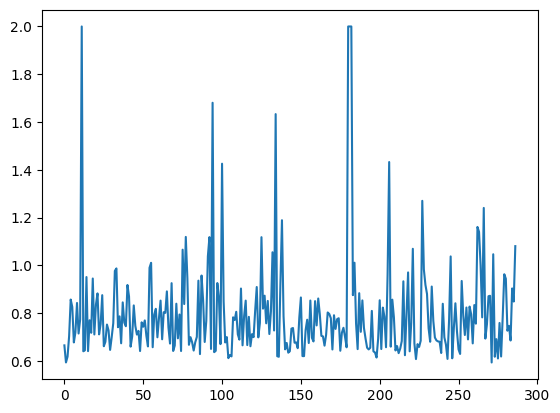

In [57]:
plt.plot(np.minimum(2, unsupervised_model.network.encoder.initial_bn.running_var.numpy()))

In [19]:
y_train.mean() #smote kell -> kell, mert csak 6% a kárigények aránya.

0.06372056901483152

In [20]:
aug = ClassificationSMOTE(p=0.2)
y_train.mean() #nem  változik, mert this will average a percentage p of the elements in the batch with other elements. The target will stay unchanged and keep the value of the most important row in the mix.
#Ez alapján nem értem, milyen p kéne...
#Ettől nem igazán javult: best valid auc 0,6251 lett...

0.06372056901483152

In [21]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":EMB_DIM,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2), #Ha 0.2-re veszem, akkor romlik kicsit: best valid auc 0,60606
                 "scheduler_params":{"step_size":50, #elég 10? # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                 #"grouped_features" : grouped_features
                 "seed":2023
                }

clf = TabNetClassifier(**tabnet_params
                      )

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


'pytorch_tabnet.tab_model'

In [30]:
# This illustrates the behaviour of the model's fit method using Compressed Sparse Row matrices
sparse_X_train = scipy.sparse.csr_matrix(X_train)  # Create a CSR matrix from X_train
sparse_X_valid = scipy.sparse.csr_matrix(X_valid)  # Create a CSR matrix from X_valid

# Fitting the model
clf.fit(
    X_train=sparse_X_train, y_train=y_train,
    eval_set=[(sparse_X_train, y_train), (sparse_X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128, #túl magas? -> nem
    num_workers=0,
    weights=1,
    drop_last=False,
    augmentations=aug, #aug, None
    from_unsupervised=unsupervised_model
)

#nagyobb patience vagy tanulási ráta segíthet -> Nem igazán, fentebb írom learning rate-nél.

#előtanítás segíthet -> nem, best valid auc 0,66416, de valószínűleg tovább kéne csinálni a pretraininget és/vagy a patience-t, mert ott max epochnál állt meg, itt meg max patience-nél.

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.71189 | train_auc: 0.50143 | valid_auc: 0.5231  |  0:00:21s
epoch 1  | loss: 0.68627 | train_auc: 0.56424 | valid_auc: 0.54017 |  0:00:43s
epoch 2  | loss: 0.68471 | train_auc: 0.58362 | valid_auc: 0.57108 |  0:01:03s
epoch 3  | loss: 0.68213 | train_auc: 0.59146 | valid_auc: 0.58082 |  0:01:25s
epoch 4  | loss: 0.6797  | train_auc: 0.56594 | valid_auc: 0.5755  |  0:01:47s
epoch 5  | loss: 0.66806 | train_auc: 0.59478 | valid_auc: 0.58886 |  0:02:07s
epoch 6  | loss: 0.66506 | train_auc: 0.54629 | valid_auc: 0.53981 |  0:02:29s
epoch 7  | loss: 0.66253 | train_auc: 0.58429 | valid_auc: 0.57889 |  0:02:50s
epoch 8  | loss: 0.66182 | train_auc: 0.59139 | valid_auc: 0.58615 |  0:03:11s
epoch 9  | loss: 0.65965 | train_auc: 0.65663 | valid_auc: 0.62591 |  0:03:33s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_valid_auc = 0.62591


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [31]:
clf.network

TabNet(
  (embedder): EmbeddingGenerator(
    (embeddings): ModuleList(
      (0): Embedding(22, 32)
      (1): Embedding(5, 32)
      (2): Embedding(6, 32)
      (3): Embedding(11, 32)
      (4): Embedding(3, 32)
      (5-6): 2 x Embedding(9, 32)
      (7): Embedding(11, 32)
      (8): Embedding(3, 32)
      (9-14): 6 x Embedding(2, 32)
      (15): Embedding(9, 32)
      (16-18): 3 x Embedding(2, 32)
      (19): Embedding(3, 32)
      (20-21): 2 x Embedding(9, 32)
      (22-33): 12 x Embedding(2, 32)
      (34): Embedding(5, 32)
    )
  )
  (tabnet): TabNetNoEmbeddings(
    (initial_bn): BatchNorm1d(1127, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (encoder): TabNetEncoder(
      (initial_bn): BatchNorm1d(1127, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (initial_splitter): FeatTransformer(
        (shared): GLU_Block(
          (shared_layers): ModuleList(
            (0): Linear(in_features=1127, out_features=32, bias=False)
      